In [ ]:
!pip install hmmlearn yfinance matplotlib pandas scikit-learn

In [ ]:
#Necessary libraries.
import pandas as pd
import numpy as np

import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from scipy.stats import skew, kurtosis
from hmmlearn import hmm

from datetime import datetime
import requests
from io import StringIO

In [ ]:
#Market data.
start_date = "1993-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")

#Time series to build features
sp500 = yf.download("^GSPC", start=start_date, end=end_date)["Close"].squeeze()
vix = yf.download("^VIX", start=start_date, end=end_date)["Close"].squeeze()
t3m = yf.download("^IRX", start=start_date, end=end_date)["Close"].squeeze()
t10y = yf.download("^TNX", start=start_date, end=end_date)["Close"].squeeze()

#Regimes are sampled weekly
data = pd.concat([sp500, vix], axis=1)
data.columns = ["SP500", "VIX"]
data = data.resample("W-FRI").ffill().dropna()
weekly_returns = np.log(data["SP500"] / data["SP500"].shift(1))

#Features---

#Macro
yield_slope = (t10y/100) - (t3m/100)

#Volatilities (annualized)
vol_1m = weekly_returns.rolling(window=4).std() * np.sqrt(52)
vol_2m = weekly_returns.rolling(window=8).std() * np.sqrt(52)
vol_1y = weekly_returns.rolling(window=52).std() * np.sqrt(52)
vol_ratio = vol_1m / vol_1y

#Drawdown
rolling_1y_high = data["SP500"].rolling(window=52).max()
drawdown = (data["SP500"] / rolling_1y_high) - 1

# Momentum measures
ret_1w = data["SP500"].pct_change(1)
ret_2w = data["SP500"].pct_change(2)
ret_1m = data["SP500"].pct_change(4)
ret_3m = data["SP500"].pct_change(12)
ret_1y = data["SP500"].pct_change(52)

ma20 =data["SP500"].rolling(4).mean()
price_vs_ma20 = (data["SP500"] - ma20) / ma20
ma200 = data["SP500"].rolling(40).mean()
price_vs_ma200 = (data["SP500"] - ma200) / ma200
ema10 = data["SP500"].ewm(span=10,adjust=False).mean()
price_vs_ema10 = (data["SP500"] - ema10) / ema10
ema20 = data["SP500"].ewm(span=20, adjust=False).mean()
price_vs_ema20 = (data["SP500"] - ema20) / ema20
ema40 = data["SP500"].ewm(span=40, adjust=False).mean()
price_vs_ema40 = (data["SP500"] - ema40) / ema40
ema200 = data["SP500"].ewm(span=200, adjust=False).mean()
price_vs_ema200 = (data["SP500"] - ema200) / ema200

ma20_slope = ma20.diff()

#Skew & Kurtosis
skew_1m = weekly_returns.rolling(4).apply(lambda x: skew(x, bias=False),raw = False)
skew_3m = weekly_returns.rolling(12).apply(lambda x: skew(x, bias=False), raw=False)

# Rolling kurtosis (excess kurtosis = 0 for normal dist)
kurt_1m = weekly_returns.rolling(4).apply(lambda x: kurtosis(x, fisher=True, bias=False), raw=False)
kurt_3m = weekly_returns.rolling(12).apply(lambda x: kurtosis(x, fisher=True, bias=False), raw=False)

#Technical Indicators
def compute_rsi(series, window):
    """
    Computes the Relative Strength Index (RSI) for a price series.

    The RSI is a momentum oscillator that measures the magnitude of recent
    price changes to evaluate overbought or oversold conditions.

    Parameters
    ----------
    series : pd.Series
        Time series of asset prices.
    window : int, default=14
        Lookback period for computing average gains and losses.

    Returns
    -------
    pd.Series
        RSI values for the given time series, ranging from 0 to 100.
    """
    # Price differences
    delta = series.diff()

    # Positive and negative gains
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    # Rolling averages of gains/losses
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()

    # Avoid divide-by-zero
    rs = avg_gain / avg_loss.replace(0, np.nan)

    # RSI formula
    rsi = 100 - (100 / (1 + rs))
    return rsi

rsi_14 = compute_rsi(data["SP500"], window=14)
rsi_20 = compute_rsi(data["SP500"], window=20)
rsi_14_ema = rsi_14.ewm(span=14, adjust=False).mean()
rsi_20_ema = rsi_20.ewm(span=20, adjust=False).mean()

std20 = data["SP500"].rolling(20).std()
upper = ma20 + 2 * std20
lower = ma20 - 2 * std20
bollinger_width = (upper - lower) / ma20

#Final set
weekly_data = pd.DataFrame({
    "SP500": data["SP500"],
    "VIX": data["VIX"],
    "Yield_Slope":yield_slope,
    "Vol_1M": vol_1m,
    "Vol_2M":vol_2m,
    "Vol_1Y":vol_1y,
    "Vol_Ratio":vol_ratio,
    "Drawdown_1Y": drawdown,
    "Ret_1W": ret_1w,
    "Ret_2W": ret_2w,
    "Ret_1M": ret_1m,
    "Ret_3M": ret_3m,
    "Ret_1Y": ret_1y,
    "Price_vs_MA20":price_vs_ma20,
    "Price_vs_MA200": price_vs_ma200,
    "Price_vs_EMA10":price_vs_ema10,
    "Price_vs_EMA20":price_vs_ema20,
    "Price_vs_EMA40":price_vs_ema40,
    "Price_vs_EMA200":price_vs_ema200,
    "MA20_Slope":ma20_slope,
    "Skew_1M":skew_1m,
    "Skew_3M":skew_3m,
    "Kurt_1M":kurt_1m,
    "Kurt_3M":kurt_3m,
    "RSI_14":rsi_14,
    "RSI_20":rsi_20,
    "RSI_14_EMA":rsi_14_ema,
    "RSI_20_EMA":rsi_20_ema,
    "Bollinger_Width":bollinger_width,

}, index=data.index)

#Tabular visualization
weekly_data.dropna(inplace=True)
weekly_data.head()

C:\Users\Tyler\AppData\Local\Temp\ipykernel_12756\4077972006.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download("^GSPC", start=start_date, end=end_date)["Close"].squeeze()
[*********************100%***********************]  1 of 1 completed
C:\Users\Tyler\AppData\Local\Temp\ipykernel_12756\4077972006.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start=start_date, end=end_date)["Close"].squeeze()
[*********************100%***********************]  1 of 1 completed
C:\Users\Tyler\AppData\Local\Temp\ipykernel_12756\4077972006.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  t3m = yf.download("^IRX", start=start_date, end=end_date)["Close"].squeeze()
[*********************100%***********************]  1 of 1 completed
C:\Users\Tyler\AppData\Local\Temp\ipykernel_12756\4077972006.py:9: FutureWarning: YF.download() has changed argument a

,SP500,VIX,Yield_Slope,Vol_1M,Vol_2M,Vol_1Y,Vol_Ratio,Drawdown_1Y,Ret_1W,Ret_2W,...,MA20_Slope,Skew_1M,Skew_3M,Kurt_1M,Kurt_3M,RSI_14,RSI_20,RSI_14_EMA,RSI_20_EMA,Bollinger_Width
Date,,,,,,,,,,,,,,,,,,,,,
1994-01-07,469.899994,10.96,0.02645,0.029359,0.031779,0.075046,0.391214,0.000000,0.007396,0.005392,...,1.492500,-0.585989,-0.726748,-0.794073,0.072960,58.813897,61.045006,60.540690,62.769597,0.030265
1994-01-14,474.910004,11.15,0.02758,0.040195,0.031980,0.073604,0.546094,0.000000,0.010662,0.018137,...,2.132500,-0.170157,-1.111892,-2.210864,1.699123,63.789192,61.435613,60.973823,62.642551,0.036359
1994-01-21,474.720001,11.09,0.02727,0.043705,0.032906,0.073521,0.594460,-0.000400,-0.000400,0.010258,...,1.834999,0.181606,-0.978089,-4.324245,1.896638,55.939915,60.752168,60.302636,62.462514,0.040682
1994-01-28,478.700012,9.94,0.02677,0.034493,0.035547,0.073694,0.468050,0.000000,0.008384,0.007980,...,3.062500,-1.513214,0.070455,2.699502,-0.835792,68.505650,62.898816,61.396371,62.504067,0.047374
1994-02-04,469.809998,15.25,0.02658,0.096184,0.067013,0.073240,1.313277,-0.018571,-0.018571,-0.010343,...,-0.022499,-1.330472,-1.371146,1.251798,2.801942,52.151248,57.644114,60.163688,62.041214,0.045806


In [ ]:
#Select features and view their correlations. I found this performed best on train set. Feel free to test a different set of features.
features = ["Ret_1W","Ret_1M","VIX","Price_vs_MA200","RSI_20_EMA","Price_vs_EMA20"]
factors = weekly_data[features]

corr_matrix = factors.corr()

print(corr_matrix)

                  Ret_1W    Ret_1M       VIX  Price_vs_MA200  RSI_20_EMA  \
Ret_1W          1.000000  0.482051 -0.267346        0.272307    0.038690   
Ret_1M          0.482051  1.000000 -0.434524        0.510301    0.133525   
VIX            -0.267346 -0.434524  1.000000       -0.650651   -0.496752   
Price_vs_MA200  0.272307  0.510301 -0.650651        1.000000    0.793353   
RSI_20_EMA      0.038690  0.133525 -0.496752        0.793353    1.000000   
Price_vs_EMA20  0.418144  0.716907 -0.676584        0.931295    0.581629   

                Price_vs_EMA20  
Ret_1W                0.418144  
Ret_1M                0.716907  
VIX                  -0.676584  
Price_vs_MA200        0.931295  
RSI_20_EMA            0.581629  
Price_vs_EMA20        1.000000  


In [ ]:
#Scale features to ensure efficient training.
scaler = StandardScaler()
scaled_factors = pd.DataFrame(scaler.fit_transform(factors),
                              index=factors.index,
                              columns=factors.columns)

print(scaled_factors.describe())

             Ret_1W        Ret_1M           VIX  Price_vs_MA200    RSI_20_EMA  \
count  1.596000e+03  1.596000e+03  1.596000e+03    1.596000e+03  1.596000e+03   
mean   2.003410e-17 -1.780809e-17  1.869849e-16    3.561618e-17 -5.342427e-17   
std    1.000313e+00  1.000313e+00  1.000313e+00    1.000313e+00  1.000313e+00   
min   -7.698131e+00 -7.007358e+00 -1.283524e+00   -5.028950e+00 -2.702040e+00   
25%   -5.113560e-01 -4.924467e-01 -7.144574e-01   -4.675570e-01 -6.845551e-01   
50%    4.869029e-02  1.244448e-01 -2.386397e-01    1.807828e-01  1.006219e-01   
75%    5.425961e-01  5.827700e-01  4.224412e-01    6.581796e-01  7.484515e-01   
max    4.978379e+00  5.307256e+00  7.360857e+00    2.091504e+00  2.271509e+00   

       Price_vs_EMA20  
count    1.596000e+03  
mean     1.780809e-17  
std      1.000313e+00  
min     -6.223733e+00  
25%     -3.945823e-01  
50%      2.006219e-01  
75%      6.404867e-01  
max      2.083737e+00  


Transition matrix:
 [[0.9653434  0.01786511 0.0167915 ]
 [0.0441827  0.95313882 0.00267848]
 [0.00926243 0.00293383 0.98780374]]

Regime Profiles:
            Ret_1W    Ret_1M        VIX  Price_vs_MA200  RSI_20_EMA  \
Cluster                                                              
0        0.000749  0.004406  21.540814        0.016560   53.546819   
1        0.000257  0.002331  31.956535       -0.010941   50.493495   
2        0.002516  0.010670  14.352371        0.054811   62.123810   

         Price_vs_EMA20  Count  
Cluster                         
0              0.007223    528  
1             -0.007074    254  
2              0.025853    814  


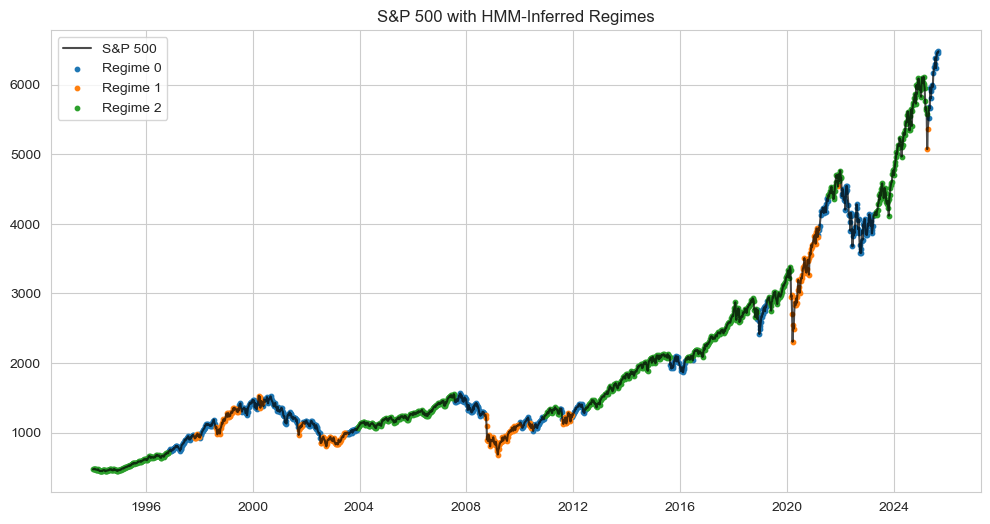

In [ ]:
#Train & Plot regimes over S&P. This will not be used for evaluation, but it's helpful to diagnose each regime. Show HMM transition matrix.
X = weekly_data[features].values

model = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100, random_state=42)
model.fit(X)

hidden_states = model.predict(X)
weekly_data["Cluster"] = hidden_states

print("Transition matrix:\n", model.transmat_)

regime_profiles = weekly_data.groupby("Cluster")[features].mean()
regime_counts = weekly_data["Cluster"].value_counts().sort_index()
regime_profiles["Count"] = regime_counts

print("\nRegime Profiles:\n", regime_profiles)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(weekly_data.index, weekly_data["SP500"], label="S&P 500",color="black",alpha=0.7)
for regime in range(model.n_components):
    mask = weekly_data["Cluster"] == regime
    plt.scatter(weekly_data.index[mask], weekly_data["SP500"][mask], s=10, label=f"Regime {regime}")
plt.legend()
plt.title("S&P 500 with HMM-Inferred Regimes")
plt.show()

In [ ]:
#Show regime profiles.
cluster_profiles = weekly_data.groupby("Cluster")[features].mean()
cluster_counts = weekly_data.groupby("Cluster").size()
cluster_profiles["Count"] = cluster_counts
print(cluster_profiles)

           Ret_1W    Ret_1M        VIX  Price_vs_MA200  RSI_20_EMA  \
Cluster                                                              
0        0.000749  0.004406  21.540814        0.016560   53.546819   
1        0.000257  0.002331  31.956535       -0.010941   50.493495   
2        0.002516  0.010670  14.352371        0.054811   62.123810   

         Price_vs_EMA20  Count  
Cluster                         
0              0.007223    528  
1             -0.007074    254  
2              0.025853    814  


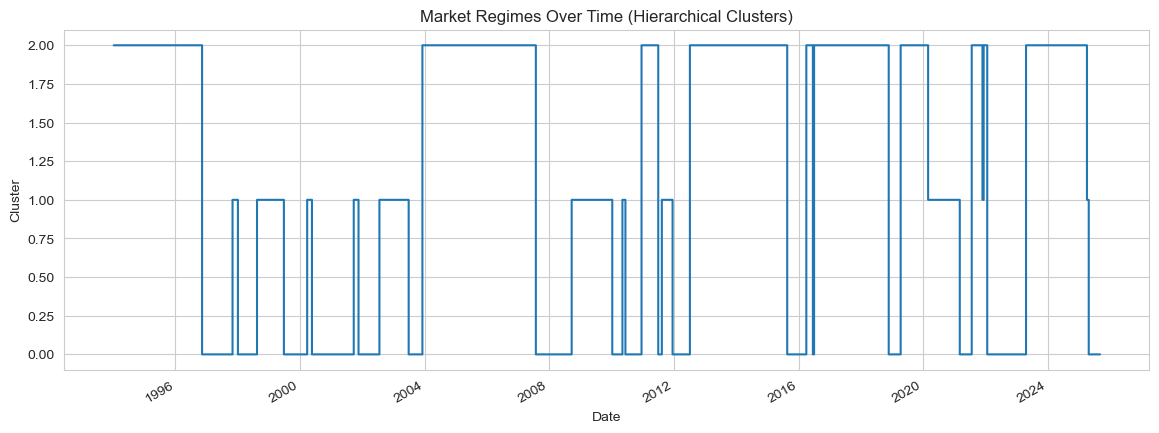

In [ ]:
#Show regime changes over time.
plt.figure(figsize=(14,5))
weekly_data["Cluster"].plot(drawstyle="steps-post")
plt.title("Market Regimes Over Time (Hierarchical Clusters)")
plt.ylabel("Cluster")
plt.show()

D:\MachineLearning\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Train Regime Profiles (1993–2015):
           Ret_1W    Ret_1M        VIX  Price_vs_MA200  RSI_20_EMA  \
Cluster                                                              
0        0.001219  0.001127  32.392475       -0.028801   48.091961   
1        0.000114  0.003779  21.410637        0.030050   55.680185   
2        0.002278  0.009603  13.971237        0.047693   60.904739   

         Price_vs_EMA20  Count  
Cluster                         
0             -0.014967    202  
1              0.012298    408  
2              0.022518    485   

Test Regime Profiles (2016–2025):
           Ret_1W    Ret_1M        VIX  Price_vs_MA200  RSI_20_EMA  \
Cluster                                                              
0        0.003162  0.018546  28.959412        0.022117   54.575578   
1        0.000279  0.001377  20.437905        0.018128   54.983173   
2        0.002884  0.012172  14.237701        0.061701   63.868435   

         Price_vs_EMA20  Count  
Cluster                      

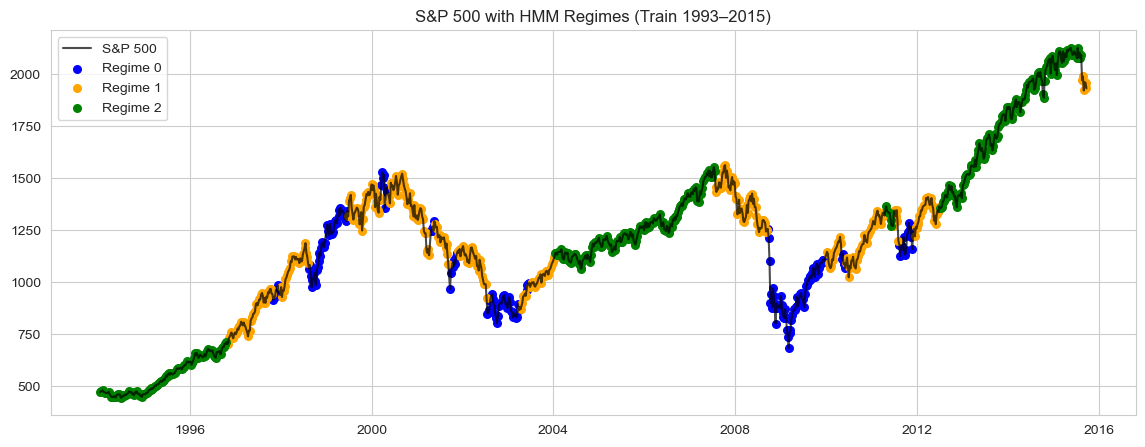

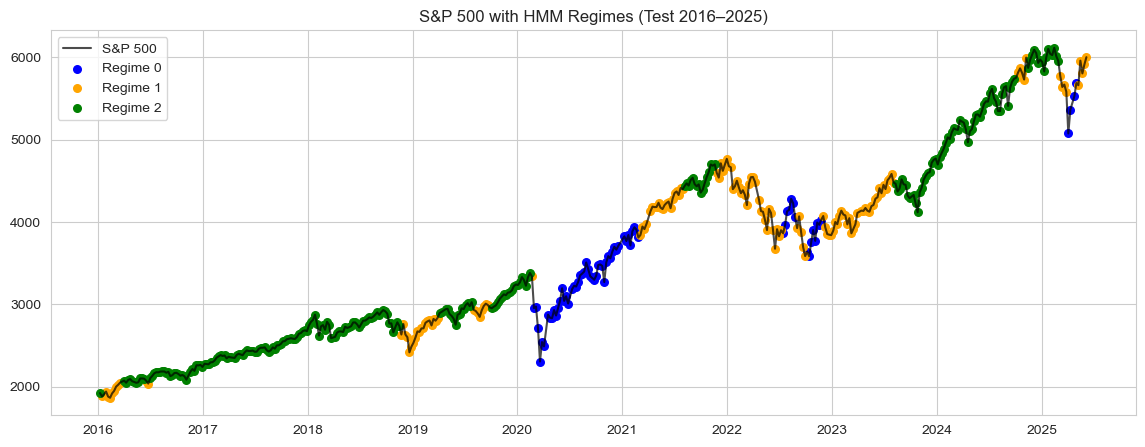

HMM Transition Matrix (Train):
 [[9.50761828e-01 4.92381717e-02 2.35131104e-49]
 [2.41549644e-02 9.68482484e-01 7.36255193e-03]
 [1.72809096e-40 8.38903642e-03 9.91610964e-01]]


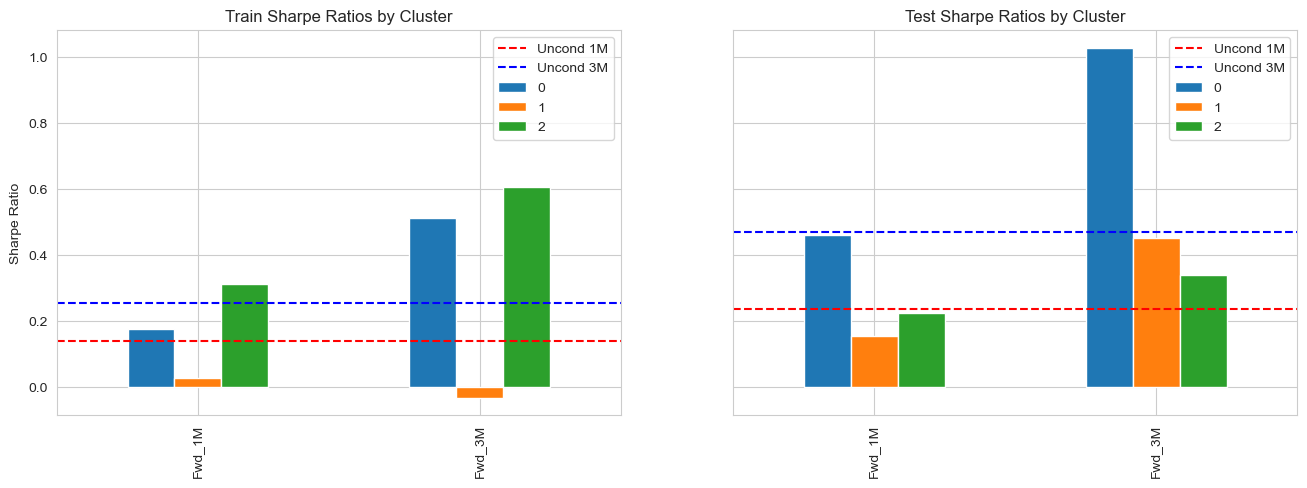

In [ ]:
#Train model on training set, show regime profiles for train & test, compute 1M & 3M Sharpe ratios, graph regimes over S&P for train & test, graph Sharpes for train & test.
train_end = "2015-12-31"
train_data = weekly_data.loc[:train_end].copy()
test_data = weekly_data.loc["2016-01-01":].copy()

X_train = train_data[features].values
X_test = test_data[features].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

n_regimes = 3
hmm_model = hmm.GaussianHMM(n_components=n_regimes, covariance_type="full", n_iter=100, random_state=42)
hmm_model.fit(X_train_scaled)

train_data["Cluster"] = hmm_model.predict(X_train_scaled)
test_data["Cluster"] = hmm_model.predict(X_test_scaled)

for df in [train_data, test_data]:
    df["Fwd_1M"] = df["SP500"].shift(-4) / df["SP500"] - 1
    df["Fwd_3M"] = df["SP500"].shift(-12) / df["SP500"] - 1

train_data.dropna(subset=["Fwd_1M", "Fwd_3M"], inplace=True)
test_data.dropna(subset=["Fwd_1M", "Fwd_3M"], inplace=True)

def regime_profiles(df, features):
    """
    Computes average feature values and observation counts for each regime.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing regime labels in column "Cluster" and feature columns.
    features : list of str
        List of feature column names to include in the regime profile.

    Returns
    -------
    pd.DataFrame
        Regime profiles with mean feature values per cluster.
        Includes an additional "Count" column with the number of observations.
    """
    profiles = df.groupby("Cluster")[features].mean()
    counts = df["Cluster"].value_counts().sort_index()
    profiles["Count"] = counts
    return profiles

train_profiles = regime_profiles(train_data, features)
test_profiles = regime_profiles(test_data, features)

print("Train Regime Profiles (1993–2015):")
print(train_profiles, "\n")

print("Test Regime Profiles (2016–2025):")
print(test_profiles, "\n")

forward_perf_test = test_data.groupby("Cluster")[["Fwd_1M", "Fwd_3M"]].mean()
forward_perf_test["Count"] = test_data.groupby("Cluster").size()

print("Forward Return Performance by Cluster (Test 2016–2025):")
print(forward_perf_test, "\n")

features_fwd = ["Fwd_1M", "Fwd_3M"]

uncond_sharpe_train = train_data[features_fwd].mean() / train_data[features_fwd].std()
sharpe_by_cluster_train = train_data.groupby("Cluster")[features_fwd].apply(
    lambda x: x.mean() / x.std()
)

print("Train (1993–2015) Unconditional Sharpe Ratios:")
print(uncond_sharpe_train, "\n")

print("Train (1993–2015) Sharpe Ratios by Cluster:")
print(sharpe_by_cluster_train, "\n")

uncond_sharpe_test = test_data[features_fwd].mean() / test_data[features_fwd].std()
sharpe_by_cluster_test = test_data.groupby("Cluster")[features_fwd].apply(
    lambda x: x.mean() / x.std()
)

print("Test (2016–2025) Unconditional Sharpe Ratios:")
print(uncond_sharpe_test, "\n")

print("Test (2016–2025) Sharpe Ratios by Cluster:")
print(sharpe_by_cluster_test, "\n")

cluster_colors = {0: "blue", 1: "orange", 2: "green"}

def plot_regimes(df, title):
    """
    Plots the S&P 500 index over time with points colored by regime.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing columns "SP500" (index level) and "Cluster" (regime label).
    title : str
        Title for the plot.

    Returns
    -------
    None
        Displays a matplotlib plot of the index with regimes highlighted.
    """
    plt.figure(figsize=(14,5))
    plt.plot(df.index, df["SP500"], color="black", alpha=0.7, label="S&P 500")
    for cluster_id in sorted(df["Cluster"].unique()):
        mask = df["Cluster"] == cluster_id
        plt.scatter(
            df.index[mask],
            df["SP500"][mask],
            color=cluster_colors[int(cluster_id)],
            label=f"Regime {cluster_id}",
            s=30
        )
    plt.title(title)
    plt.legend()
    plt.show()

plot_regimes(train_data, "S&P 500 with HMM Regimes (Train 1993–2015)")
plot_regimes(test_data, "S&P 500 with HMM Regimes (Test 2016–2025)")

print("HMM Transition Matrix (Train):\n", hmm_model.transmat_)

fig, axes = plt.subplots(1, 2, figsize=(16,5), sharey=True)

sharpe_by_cluster_train.T.plot(kind="bar", ax=axes[0])
axes[0].axhline(uncond_sharpe_train["Fwd_1M"], color="red", linestyle="--", label="Uncond 1M")
axes[0].axhline(uncond_sharpe_train["Fwd_3M"], color="blue", linestyle="--", label="Uncond 3M")
axes[0].set_title("Train Sharpe Ratios by Cluster")
axes[0].set_ylabel("Sharpe Ratio")
axes[0].legend()

sharpe_by_cluster_test.T.plot(kind="bar", ax=axes[1])
axes[1].axhline(uncond_sharpe_test["Fwd_1M"], color="red", linestyle="--", label="Uncond 1M")
axes[1].axhline(uncond_sharpe_test["Fwd_3M"], color="blue", linestyle="--", label="Uncond 3M")
axes[1].set_title("Test Sharpe Ratios by Cluster")
axes[1].legend()

plt.show()

C:\Users\Tyler\AppData\Local\Temp\ipykernel_12756\50304891.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(etfs, start=test_data.index.min(), end=test_data.index.max())["Close"]
[*********************100%***********************]  6 of 6 completed


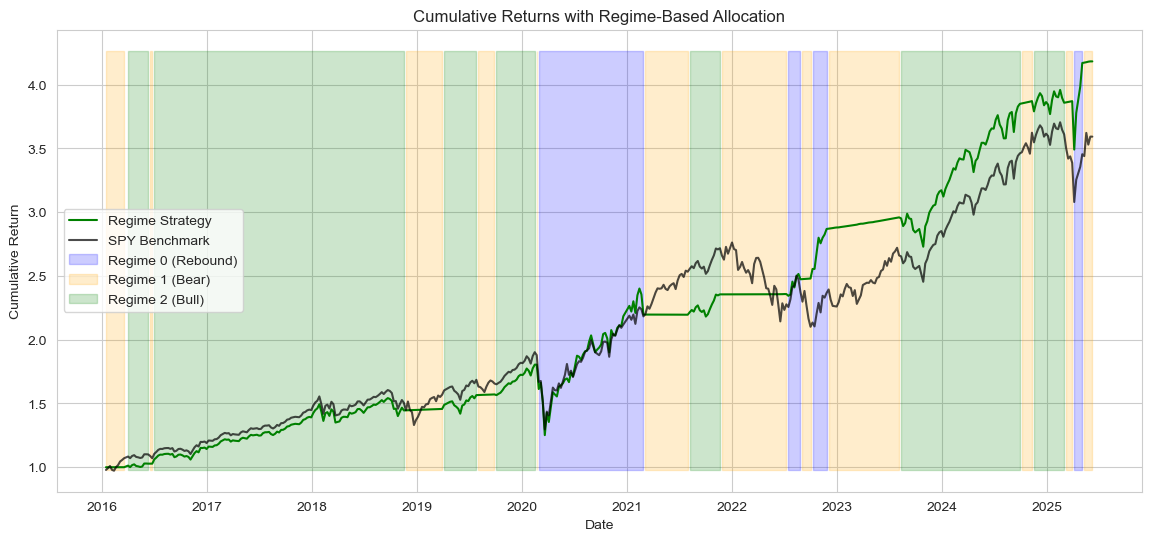

In [ ]:
#Select allocations depending on regime, graph against S&P returns.
confirm_weeks = 1 #Hyperparameter which requires a regime to stay for confirm_weeks weeks to allow a swap.

etfs = ["SPY","BIL","MTUM","SPUU","SH","SPXU"]

prices = yf.download(etfs, start=test_data.index.min(), end=test_data.index.max())["Close"]
prices = prices.reindex(test_data.index).ffill()

def regime_to_weights(regime):
    """
    Maps a regime label to portfolio asset allocation weights.

    Parameters
    ----------
    regime : int
        Regime identifier (e.g., 0, 1, 2).

    Returns
    -------
    dict
        Dictionary mapping asset tickers to portfolio weights.
        Example: {"SPY": 1.0} for full allocation to SPY.
    """
    if regime == 0:  #Rebound
        return {"MTUM": 1.0}
    elif regime == 1:  #Bear/Crash-prone
        return {"BIL": 1.0}
    elif regime == 2:  #Bull
        return {"SPY": 1.0}
    else:
        return {"SPY": 1.0}

confirmed_regimes = []
current_regime = test_data["Cluster"].iloc[0]
count = 0

for regime in test_data["Cluster"]:
    if regime == current_regime:
        count = 0
    else:
        count += 1
        if count >= confirm_weeks:
            current_regime = regime
            count = 0
    confirmed_regimes.append(current_regime)

test_data["Confirmed_Regime"] = confirmed_regimes

returns = prices.pct_change().dropna()
strategy_returns = []

for date, row in returns.iterrows():
    if date not in test_data.index:
        continue
    regime = test_data.loc[date, "Confirmed_Regime"]
    weights = regime_to_weights(int(regime))

    # compute weighted return
    port_ret = sum(weights.get(asset, 0) * row.get(asset, 0) for asset in returns.columns)
    strategy_returns.append((date, port_ret))

strategy_returns = pd.Series(
    [ret for _, ret in strategy_returns],
    index=[date for date, _ in strategy_returns],
    name="Strategy"
)

#Compare against our benchmark, which is simply buying and holding the S&P
spy_returns = returns["SPY"].loc[strategy_returns.index]

strategy_cum = (1 + strategy_returns).cumprod()
spy_cum = (1 + spy_returns).cumprod()

plt.figure(figsize=(14,6))
plt.plot(strategy_cum.index, strategy_cum, label="Regime Strategy", color="green")
plt.plot(spy_cum.index, spy_cum, label="SPY Benchmark", color="black", alpha=0.7)

cluster_colors = {0: "blue", 1: "orange", 2: "green"}

for cluster_id in sorted(test_data["Confirmed_Regime"].unique()):
    mask = test_data["Confirmed_Regime"].loc[strategy_cum.index] == cluster_id
    plt.fill_between(
        strategy_cum.index,
        strategy_cum.min()*0.98,
        strategy_cum.max()*1.02,
        where=mask,
        color=cluster_colors[cluster_id],
        alpha=0.2,
        label=f"Regime {cluster_id} (Rebound)" if cluster_id not in plt.gca().get_legend_handles_labels()[1] and cluster_id == 0 else f"Regime {cluster_id} (Bear)" if cluster_id not in plt.gca().get_legend_handles_labels()[1] and cluster_id == 1 else f"Regime {cluster_id} (Bull)" if cluster_id not in plt.gca().get_legend_handles_labels()[1] and cluster_id == 2 else  ""
    )

plt.title("Cumulative Returns with Regime-Based Allocation")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

In [ ]:
#Show performance metrics for portfolio & S&P.
def get_weekly_rf_from_test(test_data):
    """
    Downloads 3-month Treasury bill yields from FRED and converts them into a weekly risk-free rate.

    Parameters
    ----------
    test_data : pd.DataFrame
        DataFrame with a datetime index representing the test period. The earliest
        and latest dates are used to query FRED for the matching date range.

    Returns
    -------
    float
        Weekly risk-free rate (compounded from the average annualized yield).
    """
    start_date = test_data.index.min().strftime("%Y-%m-%d")
    end_date = test_data.index.max().strftime("%Y-%m-%d")

    #FRED CSV URL for weekly series
    url = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id=WGS3MO&cosd={start_date}&coed={end_date}"
    resp = requests.get(url)
    raw = pd.read_csv(StringIO(resp.text))

    data = pd.read_csv(StringIO(resp.text), parse_dates=["observation_date"], index_col="observation_date")

    if data["WGS3MO"].isnull().all():
        raise ValueError("No yield data fetched — check series or date range.")

    # FRED yields are in percent
    yld = data["WGS3MO"].dropna() / 100.0

    avg_ann = yld.mean()
    rf_weekly = (1 + avg_ann) ** (1/52.0) - 1

    print(f"Avg annual 3M T-bill yield (test period): {avg_ann:.3%}")
    print(f"Weekly risk-free rate (compound): {rf_weekly:.6%}")

    return rf_weekly

rf = get_weekly_rf_from_test(test_data)

import statsmodels.api as sm

def compute_alpha_beta(portfolio_returns, market_returns, rf_rate_weekly=rf):
    """
    Estimates alpha and beta of a portfolio relative to the market using CAPM regression.

    Parameters
    ----------
    portfolio_returns : pd.Series
        Weekly portfolio returns (datetime index).
    market_returns : pd.Series
        Weekly market returns (datetime index), aligned with `portfolio_returns`.
    rf_rate_weekly : float, optional
        Weekly risk-free rate (default: global `rf`).

    Returns
    -------
    tuple
        alpha_ann : float
            Annualized alpha from the regression.
        beta : float
            Sensitivity of the portfolio to market returns.
        r_squared : float
            R-squared statistic of the regression fit.
    """
    portfolio_excess = portfolio_returns - rf_rate_weekly
    spy_excess = market_returns - rf_rate_weekly

    spy_excess = sm.add_constant(spy_excess)  #with intercept
    model = sm.OLS(portfolio_excess, spy_excess).fit()

    alpha_weekly = model.params['const']
    beta = model.params[spy_excess.columns[1]]

    # Annualize alpha
    alpha_ann = (1 + alpha_weekly)**52 - 1

    return alpha_ann, beta, model.rsquared

def compute_performance_metrics(returns, rf_rate=rf):
    """
    Computes key performance metrics for a return series.

    Parameters
    ----------
    returns : pd.Series
        Periodic return series (e.g., weekly), indexed by datetime.
    rf_rate : float, optional
        Risk-free rate per period (default: global `rf`).

    Returns
    -------
    dict
        Dictionary containing:
        - "CAGR" : float
            Compound annual growth rate.
        - "Volatility" : float
            Annualized volatility of returns.
        - "Sharpe" : float
            Annualized Sharpe ratio.
        - "Max Drawdown" : float
            Maximum drawdown over the period.
        - "Calmar" : float
            Calmar ratio (CAGR / |Max Drawdown|).
        - "Annual Alpha" : float
            Annualized alpha relative to S&P 500.
        - "Beta" : float
            Beta relative to S&P 500.
        - "R Squared" : float
            R-squared from CAPM regression.
    """
    returns = returns.dropna()

    periods_per_year = 52

    cumulative_return = (1 + returns).prod()
    n_years = len(returns) / periods_per_year
    cagr = cumulative_return ** (1 / n_years) - 1

    vol = returns.std() * np.sqrt(periods_per_year)

    excess_ret = returns - rf_rate
    sharpe = (excess_ret.mean() / returns.std()) * np.sqrt(periods_per_year)

    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdowns = (cumulative - running_max) / running_max
    max_dd = drawdowns.min()

    calmar = cagr / abs(max_dd) if max_dd != 0 else np.nan

    alpha = compute_alpha_beta(returns, spy_returns.loc[strategy_returns.index])[0]
    beta = compute_alpha_beta(returns, spy_returns.loc[strategy_returns.index])[1]
    r2 = compute_alpha_beta(returns, spy_returns.loc[strategy_returns.index])[2]

    return {
        "CAGR": cagr,
        "Volatility": vol,
        "Sharpe": sharpe,
        "Max Drawdown": max_dd,
        "Calmar": calmar,
        "Annual Alpha": alpha,
        "Beta": beta,
        "R Squared": r2
    }

strategy_metrics = compute_performance_metrics(strategy_returns)
spy_metrics = compute_performance_metrics(spy_returns.loc[strategy_returns.index])

perf_table = pd.DataFrame([strategy_metrics, spy_metrics], index=["Regime Strategy", "SPY"])

print(perf_table.round(4))

Avg annual 3M T-bill yield (test period): 2.142%
Weekly risk-free rate (compound): 0.040757%
                   CAGR  Volatility  Sharpe  Max Drawdown  Calmar  \
Regime Strategy  0.1692      0.1637  0.9085       -0.3065   0.552   
SPY              0.1499      0.1790  0.7527       -0.3183   0.471   

                 Annual Alpha    Beta  R Squared  
Regime Strategy        0.0527  0.7223     0.6241  
SPY                    0.0000  1.0000     1.0000  


In [ ]:
#Show alpha, beta, and R^2 for the portfolio for each year.
def compute_yearly_alphas(portfolio_returns, market_returns, rf_rate_weekly=rf):
    """
    Computes annual alpha/beta for each calendar year in the test data.

    Parameters
    ----------
    portfolio_returns : pd.Series
        Weekly portfolio returns (datetime index).
    market_returns : pd.Series
        Weekly market returns (datetime index).
    rf_rate_weekly : float
        Weekly risk-free rate (scalar, already annualized to weekly).

    Returns
    -------
    pd.DataFrame
        Columns: [Alpha (annual), Beta, R_squared]
        Indexed by year.
    """
    results = {}
    years = sorted(set(portfolio_returns.index.year))

    for yr in years:
        pr = portfolio_returns[portfolio_returns.index.year == yr]
        mr = market_returns.reindex(pr.index).dropna()
        pr = pr.reindex(mr.index)

        if len(pr) < 5:  #5 weeks not enough.
            continue

        ab = compute_alpha_beta(pr, mr)
        results[yr] = {
            "Alpha (annual)": ab[0],
            "Beta": ab[1],
            "R_squared": ab[2]
        }

    return pd.DataFrame(results).T

yearly_alphas = compute_yearly_alphas(
    strategy_returns,
    spy_returns.loc[strategy_returns.index]
)

print(yearly_alphas.round(4))

      Alpha (annual)    Beta  R_squared
2016          0.0176  0.6320     0.6235
2017          0.0000  1.0000     1.0000
2018          0.0726  0.6387     0.6405
2019          0.0333  0.4629     0.4341
2020          0.0951  1.0654     0.8905
2021         -0.1061  0.6759     0.4407
2022          0.2545  0.1937     0.2207
2023         -0.0216  0.4584     0.4501
2024         -0.0035  0.8306     0.8226
2025          0.2268  0.8964     0.7212
